<a href="https://colab.research.google.com/github/OmkarV23/Time-Series-backcasting/blob/main/Backcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [ ]:
def plot_series(time, series, format = "-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("time")
    plt.ylabel("value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-09-09 15:46:10--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-09-09 15:46:10 (94.5 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



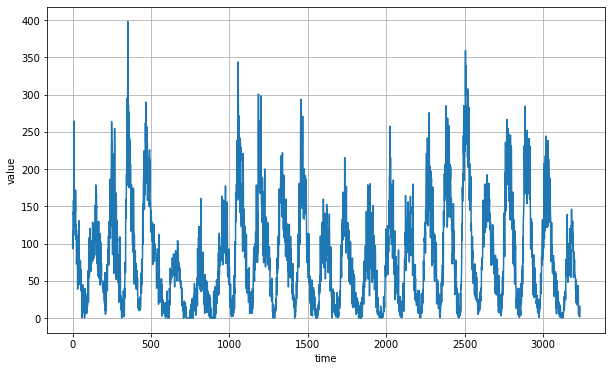

In [ ]:
time_step = []
mean_sunspot = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)
  for row in reader:
    time_step.append(int(row[0]))
    mean_sunspot.append(float(row[2]))


time = np.array(time_step)
series = np.array(mean_sunspot)
plt.figure(figsize=(10,6))
plot_series(time,series)

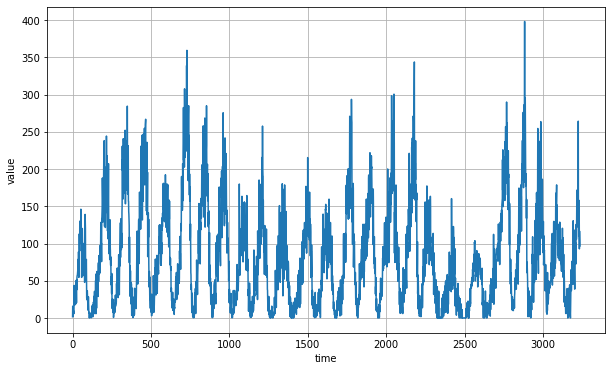

In [ ]:
time = np.array(time_step)
series = np.array(mean_sunspot)
series = series[::-1]
plt.figure(figsize=(10,6))
plot_series(time,series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
ss_train = series[:split_time]
time_valid = time[split_time:]
ss_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

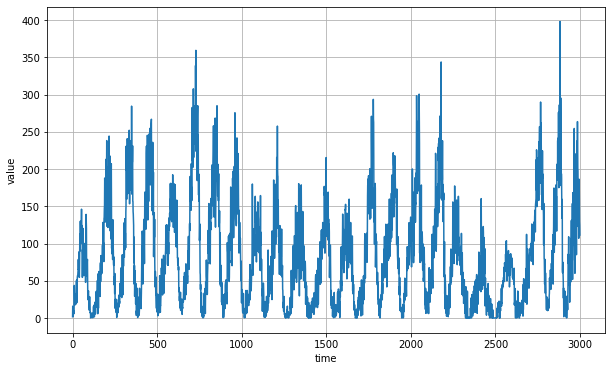

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_train,ss_train)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_backcast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    backcast = model.predict(ds)
    return backcast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(ss_train, window_size=60, batch_size=30, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=80, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
98/98 [==============================] - 7s 70ms/step - loss: 29.8733 - mae: 30.3684
Epoch 2/500
98/98 [==============================] - 7s 71ms/step - loss: 19.8898 - mae: 20.3827
Epoch 3/500
98/98 [==============================] - 7s 70ms/step - loss: 18.4861 - mae: 18.9783
Epoch 4/500
98/98 [==============================] - 7s 70ms/step - loss: 18.1233 - mae: 18.6149
Epoch 5/500
98/98 [==============================] - 7s 70ms/step - loss: 17.7365 - mae: 18.2279
Epoch 6/500
98/98 [==============================] - 7s 71ms/step - loss: 17.4272 - mae: 17.9182
Epoch 7/500
98/98 [==============================] - 7s 72ms/step - loss: 17.6974 - mae: 18.1887
Epoch 8/500
98/98 [==============================] - 7s 74ms/step - loss: 17.2690 - mae: 17.7601
Epoch 9/500
98/98 [==============================] - 7s 71ms/step - loss: 17.2152 - mae: 17.7064
Epoch 10/500
98/98 [==============================] - 7s 71ms/step - loss: 17.2212 - mae: 17.7124
Epoch 11/500
98/98 [=========

In [ ]:
rnn_backcast = model_backcast(model, series[...,np.newaxis], window_size)
rnn_backcast = rnn_backcast[split_time-window_size:-1, -1, 0]
print(rnn_backcast.shape)

(235,)


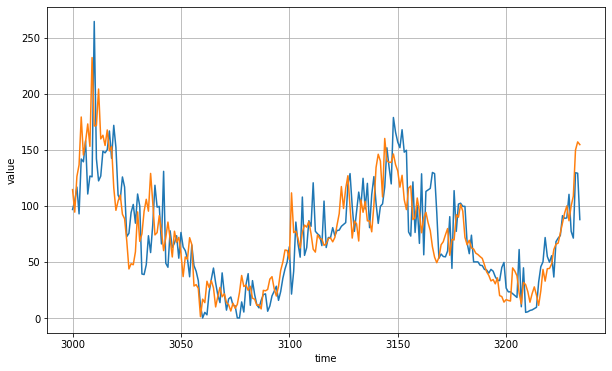

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, ss_valid[::-1])
plot_series(time_valid, rnn_backcast[::-1])

In [ ]:
model.save('my_model_new.h5')